### 딥러닝 회귀
* 딥러닝 회귀        
    * NN: 뉴럴네트워크 
    * DNN: 딥뉴렬네트워크(심층신경망)
    * CNN: 컨볼루션 뉴럴 네트워크( 특징추출)
    * RNN: 리커런트 뉴럴 네트워크( 순환신경망: 시계열)
        - LSTM
* 가중치 기반의 데이터 분류 
    - 데이터의 영향을 평준화
        - 스케일링( minmax scale)
    

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def seldata(cols=['sday','sopen','shigh','slow','sclose','svol'],where='where sday>"2022-01-01" order by sday asc'):
    fname='_db/nstock.db'
    with sqlite3.connect(fname) as conn:
        cur=conn.cursor()
        coltxt=','.join(cols)
        sql='select '+coltxt+' from stockdb '+where
        #print(sql)
        res=cur.execute(sql).fetchall()
    return res

res=seldata(where=' order by sday asc')    
res[:5]

[('1996-12-26', 23000, 23000, 23000, 23000, 0),
 ('1996-12-27', 23000, 23000, 23000, 23000, 0),
 ('1997-01-03', 20000, 20100, 20000, 20000, 145680),
 ('1997-01-04', 20000, 20000, 20000, 20000, 277690),
 ('1997-01-06', 20000, 20000, 20000, 20000, 436190)]

In [3]:
cols=['sday','sopen','shigh','slow','sclose','svol']
df = pd.DataFrame(res,columns=cols)
mdf=df.set_index('sday')
mdf.tail()

,sopen,shigh,slow,sclose,svol
sday,,,,,
2022-05-06,108000,108500,106500,107500,2566813
2022-05-09,107000,109000,106500,107500,2203472
2022-05-10,107000,111000,107000,110000,4141923
2022-05-11,110500,112500,108000,110500,3658168
2022-05-12,109500,111500,108500,110500,1938788


In [50]:
mdf['y']=mdf['sclose'].shift(periods=-1)
sdf=mdf.iloc[2000:-1,:].copy()
sdf.tail()

,sopen,shigh,slow,sclose,svol,y
sday,,,,,,
2022-05-04,110500,111000,108500,109500,2491890,107500.0
2022-05-06,108000,108500,106500,107500,2566813,107500.0
2022-05-09,107000,109000,106500,107500,2203472,110000.0
2022-05-10,107000,111000,107000,110000,4141923,110500.0
2022-05-11,110500,112500,108000,110500,3658168,110500.0


In [51]:
sdf.describe()

,sopen,shigh,slow,sclose,svol,y
count,4347.000000,4347.00000,4347.000000,4347.000000,4.347000e+03,4347.000000
mean,46375.730389,47033.57718,45654.761905,46303.919945,6.256912e+06,46326.073154
std,31418.086755,31798.96885,30966.898622,31379.546838,5.645681e+06,31390.867729
min,6000.000000,6240.00000,5770.000000,5850.000000,8.425620e+05,5850.000000
25%,24325.000000,24700.00000,23850.000000,24300.000000,3.046764e+06,24300.000000
50%,32800.000000,33250.00000,32350.000000,32750.000000,4.582101e+06,32750.000000
75%,68400.000000,69600.00000,67550.000000,68500.000000,7.310902e+06,68550.000000
max,149000.000000,150500.00000,142500.000000,148500.000000,6.710867e+07,148500.000000


In [52]:
smin=np.min(sdf[['sopen','shigh','slow','sclose']].values)
smax=np.max(sdf[['sopen','shigh','slow','sclose']].values)
vmin=np.min(sdf[['svol']].values)
vmax=np.max(sdf[['svol']].values)
print(smin,smax,vmin,vmax)

5770 150500 842562 67108666


In [53]:
sdiff=smax-smin
vdiff=vmax-vmin
sdf['ropen']=(sdf['sopen']-smin)/sdiff
sdf['rhigh']=(sdf['shigh']-smin)/sdiff
sdf['rlow']=(sdf['slow']-smin)/sdiff
sdf['rclose']=(sdf['sclose']-smin)/sdiff
sdf['ry']=(sdf['y']-smin)/sdiff
sdf['rvol']=(sdf['svol']-vmin)/vdiff

In [64]:
mxdf=sdf.copy()
mxdf.reset_index(drop=True, inplace=True)

In [66]:
xval=list(mxdf[['ropen','rhigh','rlow','rclose','rvol']].rolling(window=5))[5:]


In [67]:
X=np.array(xval)
Y=sdf['ry'].values[5:]
print(X.shape,Y.shape)

(4342, 5, 5) (4342,)


In [68]:
X_train=X[:-100]
Y_train=Y[:-100]
X_test=X[-100:]
Y_test=Y[-100:]

In [69]:
X_train.shape

(4242, 5, 5)

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.metrics import CosineSimilarity,RootMeanSquaredError

In [87]:
# 모델생성
model=Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.compile(loss='mse',optimizer='Adam',metrics=['CosineSimilarity'])
hist=model.fit(X_train,Y_train,epochs=100,batch_size=100)

Epoch 1/100
43/43 [==============================] - 1s 3ms/step - loss: 0.0167 - cosine_similarity: 0.9500
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 2.6096e-04 - cosine_similarity: 1.0000
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 1.9007e-04 - cosine_similarity: 1.0000
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 1.8203e-04 - cosine_similarity: 1.0000
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 1.7209e-04 - cosine_similarity: 1.0000
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 1.6693e-04 - cosine_similarity: 1.0000
Epoch 7/100
43/43 [==============================] - 0s 3ms/step - loss: 1.6644e-04 - cosine_similarity: 1.0000
Epoch 8/100
43/43 [==============================] - 0s 3ms/step - loss: 1.6621e-04 - cosine_similarity: 1.0000
Epoch 9/100
43/43 [==============================] - 0s 3ms/step - loss: 1.6144e-04 - cosine_similarity: 1.0

In [91]:
hist.history.keys()

dict_keys(['loss', 'cosine_similarity'])

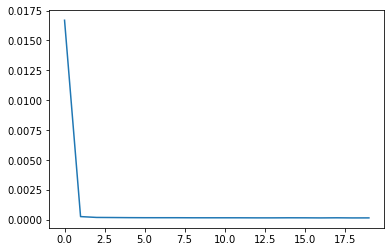

In [92]:
plt.plot(hist.history['loss'][:20])

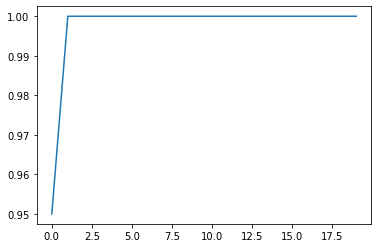

In [94]:
plt.plot(hist.history['cosine_similarity'][:20])

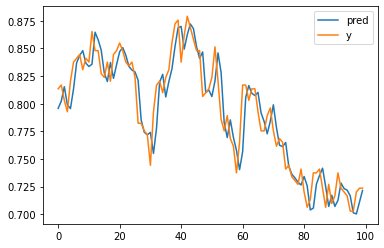

In [98]:
pred=model.predict(X_test)
plt.plot(pred,label='pred')
plt.plot(Y_test,label='y')
plt.legend()
plt.show()

In [112]:
sdf.tail()

,sopen,shigh,slow,sclose,svol,y,ropen,rhigh,rlow,rclose,ry,rvol
sday,,,,,,,,,,,,
2022-05-04,110500,111000,108500,109500,2491890,107500.0,0.723623,0.727078,0.709804,0.716714,0.702895,0.024889
2022-05-06,108000,108500,106500,107500,2566813,107500.0,0.706350,0.709804,0.695986,0.702895,0.702895,0.026020
2022-05-09,107000,109000,106500,107500,2203472,110000.0,0.699440,0.713259,0.695986,0.702895,0.720169,0.020537
2022-05-10,107000,111000,107000,110000,4141923,110500.0,0.699440,0.727078,0.699440,0.720169,0.723623,0.049790
2022-05-11,110500,112500,108000,110500,3658168,110500.0,0.723623,0.737442,0.706350,0.723623,0.723623,0.042489


In [113]:
fdf=sdf.iloc[-100:,[3,-2]].copy()
fdf['pred']=pred
fdf['yt']=Y_test
fdf['shortL']=np.round(pred*sdiff+smin)
fdf['longL']=fdf['shortL'].rolling(window=5).mean()
fdf[5:]

,sclose,ry,pred,yt,shortL,longL
sday,,,,,,
2021-12-21,124500,0.837629,0.813484,0.837629,123506.0,122298.0
2021-12-22,127000,0.841083,0.836921,0.841083,126898.0,123302.4
2021-12-23,127500,0.844538,0.843626,0.844538,127868.0,124120.4
2021-12-24,128000,0.830719,0.847988,0.830719,128499.0,125537.6
2021-12-27,126000,0.841083,0.836718,0.841083,126868.0,126727.8
...,...,...,...,...,...,...
2022-05-04,109500,0.702895,0.716739,0.702895,109504.0,110052.4
2022-05-06,107500,0.702895,0.701362,0.702895,107278.0,109727.4
2022-05-09,107500,0.720169,0.700352,0.720169,107132.0,108921.2


In [118]:
def simStock(srcdf,stxt='shortmv',ltxt='longmv'):
    mdf=srcdf.copy()
    findex=mdf.iloc[:1,:].index[0]
    lindex=mdf.iloc[-1:,:].index[0]
    lindex
    invest=200000
    beforePos=-1
    beforeHold=0

    for i,row in mdf.iloc[10:,:].iterrows():
        if(row[stxt]>=row[ltxt]):
            nowpos=1 # short 상위
        else:
            nowpos=-1 # short 하위
        if beforePos==-1 and nowpos==1 and beforeHold==0:
            timing=1# 매수타이밍
            hold=1
            mdf.loc[i,'cash']=-row['sclose']
            mdf.loc[i,'hold']=1
        elif beforePos==1 and nowpos==-1 and beforeHold==1:
            timing=-1# 매수타이밍
            hold=0
            mdf.loc[i,'cash']=row['sclose']
            mdf.loc[i,'hold']=0
        else:
            mdf.loc[i,'cash']=0
            timing=0 # 홀드
            hold=beforeHold
            mdf.loc[i,'hold']=beforeHold
        beforeHold=hold
        beforePos=nowpos
        mdf.loc[findex,'cash']=invest
        mdf['cumcash']=mdf['cash'].cumsum()
        mdf['balalce']=mdf['sclose']*mdf['hold']+mdf['cumcash']
    mdf.tail()
    ecash=mdf.loc[lindex,'balalce']-invest
    erate=ecash/invest
    return(invest,ecash,erate)

In [119]:
simStock(fdf[5:],stxt='shortL',ltxt='longL')

(200000, -14500.0, -0.0725)

<AxesSubplot:xlabel='sday'>

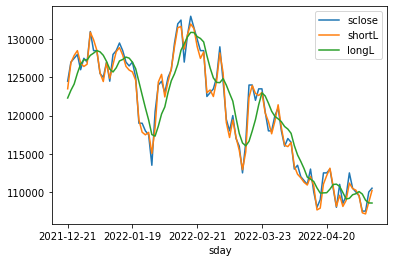

In [122]:
fdf.iloc[5:,[0,4,5]].plot()
